In [1]:
trial_number_ml = "005"
random_state_init = 555

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model2_files = ['../../data_for_ml/ml_datasets_set2/model2_rna_bin_protein_bin/data.pkl']

# Load datasets
model2_df = load_and_concatenate_datasets(model2_files)

# Preprocess datasets
X2, y2 = preprocess_data(model2_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X2, y2)

# Output shapes
print(f"Model 2 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 2 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 16:32:47,337] A new study created in memory with name: no-name-5e010238-d8d5-4602-a0d9-994637078625


[I 2024-05-01 16:33:56,421] Trial 1 finished with value: 0.8300830971464561 and parameters: {'n_estimators': 313, 'max_depth': 82, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8300830971464561.


[I 2024-05-01 16:34:33,320] Trial 2 finished with value: 0.8664208291429212 and parameters: {'n_estimators': 414, 'max_depth': 42, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8664208291429212.


[I 2024-05-01 16:34:44,470] Trial 0 finished with value: 0.86195867491543 and parameters: {'n_estimators': 476, 'max_depth': 46, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8664208291429212.


[I 2024-05-01 16:35:16,710] Trial 3 finished with value: 0.853987748758114 and parameters: {'n_estimators': 655, 'max_depth': 80, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8664208291429212.


[I 2024-05-01 16:35:31,999] Trial 4 finished with value: 0.8393274007253224 and parameters: {'n_estimators': 454, 'max_depth': 46, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8664208291429212.


[I 2024-05-01 16:35:33,420] Trial 7 pruned. 


[I 2024-05-01 16:35:38,695] Trial 8 pruned. 


[I 2024-05-01 16:35:42,480] Trial 9 pruned. 


[I 2024-05-01 16:35:47,673] Trial 5 pruned. 


[I 2024-05-01 16:35:54,096] Trial 6 finished with value: 0.8405987464318004 and parameters: {'n_estimators': 369, 'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8664208291429212.


[I 2024-05-01 16:36:00,499] Trial 10 pruned. 


[I 2024-05-01 16:36:02,767] Trial 11 pruned. 


[I 2024-05-01 16:36:08,973] Trial 12 finished with value: 0.8581314316480257 and parameters: {'n_estimators': 121, 'max_depth': 42, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 0.8664208291429212.


[I 2024-05-01 16:36:15,830] Trial 13 finished with value: 0.8610012291876187 and parameters: {'n_estimators': 107, 'max_depth': 98, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 0.8664208291429212.


[I 2024-05-01 16:36:26,571] Trial 15 pruned. 


[I 2024-05-01 16:36:27,509] Trial 14 finished with value: 0.8568585621552435 and parameters: {'n_estimators': 111, 'max_depth': 21, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8664208291429212.


[I 2024-05-01 16:36:35,143] Trial 16 pruned. 


[I 2024-05-01 16:36:59,824] Trial 18 pruned. 


[I 2024-05-01 16:37:00,897] Trial 19 pruned. 


[I 2024-05-01 16:37:08,430] Trial 20 pruned. 


[I 2024-05-01 16:37:45,772] Trial 21 pruned. 


[I 2024-05-01 16:38:27,730] Trial 17 finished with value: 0.8574939810440985 and parameters: {'n_estimators': 600, 'max_depth': 23, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8664208291429212.


[I 2024-05-01 16:38:46,218] Trial 22 finished with value: 0.8603647944412277 and parameters: {'n_estimators': 494, 'max_depth': 27, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8664208291429212.


[I 2024-05-01 16:39:01,174] Trial 25 finished with value: 0.861003260902691 and parameters: {'n_estimators': 206, 'max_depth': 98, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.8664208291429212.


[I 2024-05-01 16:39:07,051] Trial 27 pruned. 


[I 2024-05-01 16:40:15,455] Trial 24 finished with value: 0.8616381718627778 and parameters: {'n_estimators': 989, 'max_depth': 96, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.8664208291429212.


[I 2024-05-01 16:40:17,069] Trial 23 finished with value: 0.861639695649082 and parameters: {'n_estimators': 988, 'max_depth': 26, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8664208291429212.


[I 2024-05-01 16:40:31,157] Trial 30 pruned. 


[I 2024-05-01 16:40:40,118] Trial 29 pruned. 


[I 2024-05-01 16:40:51,124] Trial 31 pruned. 


[I 2024-05-01 16:40:52,127] Trial 32 pruned. 


[I 2024-05-01 16:41:01,624] Trial 33 pruned. 


[I 2024-05-01 16:41:11,303] Trial 26 finished with value: 0.8594068407846482 and parameters: {'n_estimators': 997, 'max_depth': 100, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.8664208291429212.


[I 2024-05-01 16:41:28,720] Trial 28 finished with value: 0.8619541035565172 and parameters: {'n_estimators': 961, 'max_depth': 66, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.8664208291429212.


[I 2024-05-01 16:44:05,953] Trial 34 finished with value: 0.8651474517213705 and parameters: {'n_estimators': 983, 'max_depth': 76, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8664208291429212.


[I 2024-05-01 16:44:10,084] Trial 36 finished with value: 0.8667413321955729 and parameters: {'n_estimators': 917, 'max_depth': 70, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 36 with value: 0.8667413321955729.


[I 2024-05-01 16:44:15,461] Trial 35 finished with value: 0.8670608193906887 and parameters: {'n_estimators': 1000, 'max_depth': 69, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 35 with value: 0.8670608193906887.


[I 2024-05-01 16:44:19,914] Trial 37 finished with value: 0.8638705187984439 and parameters: {'n_estimators': 922, 'max_depth': 70, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 35 with value: 0.8670608193906887.


[I 2024-05-01 16:46:55,287] Trial 38 finished with value: 0.8686511443635144 and parameters: {'n_estimators': 899, 'max_depth': 71, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 38 with value: 0.8686511443635144.


[I 2024-05-01 16:47:05,809] Trial 40 finished with value: 0.8727948272534259 and parameters: {'n_estimators': 873, 'max_depth': 79, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.8727948272534259.


[I 2024-05-01 16:47:10,151] Trial 39 finished with value: 0.8721578845782666 and parameters: {'n_estimators': 923, 'max_depth': 79, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.8727948272534259.


[I 2024-05-01 16:47:15,488] Trial 41 finished with value: 0.8731138065197737 and parameters: {'n_estimators': 902, 'max_depth': 81, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 41 with value: 0.8731138065197737.


[I 2024-05-01 16:49:42,315] Trial 43 finished with value: 0.874708194922744 and parameters: {'n_estimators': 768, 'max_depth': 87, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 43 with value: 0.874708194922744.


[I 2024-05-01 16:49:49,196] Trial 42 finished with value: 0.8718399211694552 and parameters: {'n_estimators': 882, 'max_depth': 85, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 43 with value: 0.874708194922744.


[I 2024-05-01 16:49:55,800] Trial 45 finished with value: 0.8715194181168033 and parameters: {'n_estimators': 785, 'max_depth': 84, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 43 with value: 0.874708194922744.


[I 2024-05-01 16:50:11,012] Trial 44 finished with value: 0.8702450248377168 and parameters: {'n_estimators': 893, 'max_depth': 83, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 43 with value: 0.874708194922744.


[I 2024-05-01 16:52:14,772] Trial 46 finished with value: 0.874708194922744 and parameters: {'n_estimators': 769, 'max_depth': 85, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 43 with value: 0.874708194922744.


[I 2024-05-01 16:52:19,645] Trial 47 finished with value: 0.8743907394427005 and parameters: {'n_estimators': 778, 'max_depth': 85, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 43 with value: 0.874708194922744.


[I 2024-05-01 16:52:23,281] Trial 48 finished with value: 0.8775795162486413 and parameters: {'n_estimators': 808, 'max_depth': 86, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 48 with value: 0.8775795162486413.


[I 2024-05-01 16:52:24,889] Trial 49 finished with value: 0.8785354381901482 and parameters: {'n_estimators': 777, 'max_depth': 87, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 49 with value: 0.8785354381901482.


Best trial for RandomForestClassifier:
  Value: 0.8785354381901482
  Params: 
    n_estimators: 777
    max_depth: 87
    min_samples_split: 5
    min_samples_leaf: 1
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 777, 'max_depth': 87, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2024-05-01 16:52:43,732] A new study created in memory with name: no-name-f41f32c5-ee98-4f8b-a54f-6504d638b152


RandomForestClassifier accuracy: 0.8599



[I 2024-05-01 16:52:47,110] Trial 1 finished with value: 0.8281712532634422 and parameters: {'n_estimators': 119, 'max_depth': 5, 'learning_rate': 0.23435747057885822, 'min_child_weight': 3, 'subsample': 0.7504643288769528, 'colsample_bytree': 0.669260650159635, 'gamma': 4.783028016397067, 'reg_lambda': 0.25611077239857566, 'reg_alpha': 4.599287013595434}. Best is trial 1 with value: 0.8281712532634422.


[I 2024-05-01 16:52:49,480] Trial 0 finished with value: 0.8514420097725495 and parameters: {'n_estimators': 140, 'max_depth': 8, 'learning_rate': 0.22593542241133116, 'min_child_weight': 8, 'subsample': 0.8151539030448164, 'colsample_bytree': 0.7543687525604632, 'gamma': 0.8971797657384206, 'reg_lambda': 1.0388560925215158, 'reg_alpha': 4.639930386249474}. Best is trial 0 with value: 0.8514420097725495.


[I 2024-05-01 16:52:49,601] Trial 2 finished with value: 0.8364560793994251 and parameters: {'n_estimators': 149, 'max_depth': 3, 'learning_rate': 0.08170564075759632, 'min_child_weight': 8, 'subsample': 0.9205090605499973, 'colsample_bytree': 0.9288595146432722, 'gamma': 3.3423476166791626, 'reg_lambda': 1.1333661623851516, 'reg_alpha': 0.038112117509021236}. Best is trial 0 with value: 0.8514420097725495.


[I 2024-05-01 16:53:09,900] Trial 4 finished with value: 0.8520825079490851 and parameters: {'n_estimators': 194, 'max_depth': 8, 'learning_rate': 0.19642701700507093, 'min_child_weight': 8, 'subsample': 0.7116769058727612, 'colsample_bytree': 0.9117477721528592, 'gamma': 2.550808768489083, 'reg_lambda': 0.025311584982170943, 'reg_alpha': 0.016316184904456826}. Best is trial 4 with value: 0.8520825079490851.


[I 2024-05-01 16:53:21,982] Trial 5 finished with value: 0.8562236511951564 and parameters: {'n_estimators': 269, 'max_depth': 8, 'learning_rate': 0.0667517203771074, 'min_child_weight': 5, 'subsample': 0.5882095839323138, 'colsample_bytree': 0.8753929834033385, 'gamma': 4.5679464102964875, 'reg_lambda': 0.10829171906113229, 'reg_alpha': 0.08941851423738187}. Best is trial 5 with value: 0.8562236511951564.


[I 2024-05-01 16:53:28,908] Trial 6 pruned. 


[I 2024-05-01 16:53:36,075] Trial 7 finished with value: 0.8565436463190403 and parameters: {'n_estimators': 251, 'max_depth': 5, 'learning_rate': 0.1612672319685607, 'min_child_weight': 5, 'subsample': 0.9716435137182193, 'colsample_bytree': 0.7067126580815594, 'gamma': 2.2796472971870054, 'reg_lambda': 0.025403422843016218, 'reg_alpha': 0.5202888841436706}. Best is trial 7 with value: 0.8565436463190403.


[I 2024-05-01 16:54:02,036] Trial 3 finished with value: 0.8495286421032315 and parameters: {'n_estimators': 809, 'max_depth': 3, 'learning_rate': 0.11794227741762119, 'min_child_weight': 9, 'subsample': 0.5510700879365347, 'colsample_bytree': 0.6719817017772509, 'gamma': 0.12742678163062793, 'reg_lambda': 6.8365536721849445, 'reg_alpha': 0.012241620862425827}. Best is trial 7 with value: 0.8565436463190403.


[I 2024-05-01 16:54:02,627] Trial 9 finished with value: 0.8638771218724287 and parameters: {'n_estimators': 268, 'max_depth': 6, 'learning_rate': 0.19679268652662998, 'min_child_weight': 4, 'subsample': 0.6012424920873183, 'colsample_bytree': 0.8129815749191726, 'gamma': 1.8268061504310555, 'reg_lambda': 0.2146718827007851, 'reg_alpha': 0.8093230374815824}. Best is trial 9 with value: 0.8638771218724287.


[I 2024-05-01 16:54:06,465] Trial 12 pruned. 


[I 2024-05-01 16:54:28,229] Trial 8 finished with value: 0.8460198701734069 and parameters: {'n_estimators': 969, 'max_depth': 3, 'learning_rate': 0.09998830077642745, 'min_child_weight': 9, 'subsample': 0.9607062115922482, 'colsample_bytree': 0.6552117465606955, 'gamma': 3.183262430119699, 'reg_lambda': 0.12466786115098957, 'reg_alpha': 0.1219616409381433}. Best is trial 9 with value: 0.8638771218724287.


[I 2024-05-01 16:54:34,014] Trial 10 finished with value: 0.8692957059701947 and parameters: {'n_estimators': 524, 'max_depth': 10, 'learning_rate': 0.2354648038148552, 'min_child_weight': 2, 'subsample': 0.817478273189221, 'colsample_bytree': 0.5528301745646518, 'gamma': 0.2717189118271651, 'reg_lambda': 0.12465050964660647, 'reg_alpha': 0.352638168920353}. Best is trial 10 with value: 0.8692957059701947.


[I 2024-05-01 16:54:52,652] Trial 13 finished with value: 0.8626022206645739 and parameters: {'n_estimators': 501, 'max_depth': 10, 'learning_rate': 0.2691628232784217, 'min_child_weight': 2, 'subsample': 0.5231031994937849, 'colsample_bytree': 0.5142913498152684, 'gamma': 1.6750030411804901, 'reg_lambda': 0.5528666793307113, 'reg_alpha': 1.017103834355445}. Best is trial 10 with value: 0.8692957059701947.


[I 2024-05-01 16:55:09,201] Trial 15 finished with value: 0.8689752029175428 and parameters: {'n_estimators': 470, 'max_depth': 10, 'learning_rate': 0.2973332413342597, 'min_child_weight': 1, 'subsample': 0.8410674799789182, 'colsample_bytree': 0.5180880508553177, 'gamma': 1.4651796733664, 'reg_lambda': 0.6758686447492431, 'reg_alpha': 0.7221044674000292}. Best is trial 10 with value: 0.8692957059701947.


[I 2024-05-01 16:55:36,259] Trial 11 finished with value: 0.8683407998862238 and parameters: {'n_estimators': 881, 'max_depth': 9, 'learning_rate': 0.22027260665899434, 'min_child_weight': 4, 'subsample': 0.742615189346727, 'colsample_bytree': 0.9887890971562694, 'gamma': 0.5432241944013627, 'reg_lambda': 0.07092130076577392, 'reg_alpha': 0.14305389040184874}. Best is trial 10 with value: 0.8692957059701947.


[I 2024-05-01 16:55:45,417] Trial 14 finished with value: 0.859088877375837 and parameters: {'n_estimators': 431, 'max_depth': 6, 'learning_rate': 0.011702944693752049, 'min_child_weight': 1, 'subsample': 0.8426467065999311, 'colsample_bytree': 0.5700666488790067, 'gamma': 1.5230775518072117, 'reg_lambda': 0.010295893769762672, 'reg_alpha': 0.8478875426642737}. Best is trial 10 with value: 0.8692957059701947.


[I 2024-05-01 16:55:49,186] Trial 17 finished with value: 0.8705675596054409 and parameters: {'n_estimators': 457, 'max_depth': 10, 'learning_rate': 0.29273823614466044, 'min_child_weight': 1, 'subsample': 0.8454979572998328, 'colsample_bytree': 0.5053084443746594, 'gamma': 1.0131750417922536, 'reg_lambda': 2.474725514961804, 'reg_alpha': 0.26445832144394854}. Best is trial 17 with value: 0.8705675596054409.


[I 2024-05-01 16:56:11,844] Trial 18 finished with value: 0.8702511199829337 and parameters: {'n_estimators': 462, 'max_depth': 10, 'learning_rate': 0.2779766573383246, 'min_child_weight': 1, 'subsample': 0.8477263383022697, 'colsample_bytree': 0.5041326644789953, 'gamma': 1.1334592803800674, 'reg_lambda': 2.1217690825397106, 'reg_alpha': 1.9197761602019652}. Best is trial 17 with value: 0.8705675596054409.


[I 2024-05-01 16:56:17,382] Trial 19 finished with value: 0.8680177571897317 and parameters: {'n_estimators': 403, 'max_depth': 10, 'learning_rate': 0.29345566965778264, 'min_child_weight': 1, 'subsample': 0.853701766712518, 'colsample_bytree': 0.5823240449693403, 'gamma': 1.1110011214448527, 'reg_lambda': 1.4050365978054542, 'reg_alpha': 1.967806640074562}. Best is trial 17 with value: 0.8705675596054409.


[I 2024-05-01 16:56:18,595] Trial 20 finished with value: 0.8689726632737026 and parameters: {'n_estimators': 367, 'max_depth': 10, 'learning_rate': 0.29437188356763416, 'min_child_weight': 2, 'subsample': 0.8763863230301426, 'colsample_bytree': 0.6160872460634694, 'gamma': 0.8661753242408577, 'reg_lambda': 2.3057463732235046, 'reg_alpha': 0.2777130735567505}. Best is trial 17 with value: 0.8705675596054409.


[I 2024-05-01 16:56:29,269] Trial 16 finished with value: 0.8743932790865407 and parameters: {'n_estimators': 402, 'max_depth': 10, 'learning_rate': 0.013588124499158916, 'min_child_weight': 1, 'subsample': 0.8293036042013303, 'colsample_bytree': 0.5014377983780067, 'gamma': 1.1442339737899154, 'reg_lambda': 0.012170802495604453, 'reg_alpha': 1.278719061339425}. Best is trial 16 with value: 0.8743932790865407.


[I 2024-05-01 16:56:42,925] Trial 21 finished with value: 0.8702536596267739 and parameters: {'n_estimators': 354, 'max_depth': 9, 'learning_rate': 0.29880499833404817, 'min_child_weight': 2, 'subsample': 0.8898603034719493, 'colsample_bytree': 0.5989703228660196, 'gamma': 0.9556390388604885, 'reg_lambda': 2.6682998887407092, 'reg_alpha': 2.0614715415178635}. Best is trial 16 with value: 0.8743932790865407.


[I 2024-05-01 16:56:56,219] Trial 23 finished with value: 0.8574955048304025 and parameters: {'n_estimators': 601, 'max_depth': 9, 'learning_rate': 0.2593417143623527, 'min_child_weight': 6, 'subsample': 0.9211463669749769, 'colsample_bytree': 0.6013882816807391, 'gamma': 2.3779970541808115, 'reg_lambda': 9.388709970179574, 'reg_alpha': 1.7797438692130352}. Best is trial 16 with value: 0.8743932790865407.


[I 2024-05-01 16:56:58,359] Trial 24 pruned. 


[I 2024-05-01 16:57:00,119] Trial 22 finished with value: 0.8702455327664849 and parameters: {'n_estimators': 609, 'max_depth': 9, 'learning_rate': 0.2673268063214356, 'min_child_weight': 3, 'subsample': 0.9042797103505437, 'colsample_bytree': 0.6246429641642002, 'gamma': 0.8304081940487061, 'reg_lambda': 2.428356587329579, 'reg_alpha': 2.163424939359307}. Best is trial 16 with value: 0.8743932790865407.


[I 2024-05-01 16:57:01,405] Trial 27 pruned. 


[I 2024-05-01 16:57:10,221] Trial 26 pruned. 


[I 2024-05-01 16:57:16,691] Trial 29 finished with value: 0.8635535712471683 and parameters: {'n_estimators': 342, 'max_depth': 7, 'learning_rate': 0.16304263287934567, 'min_child_weight': 2, 'subsample': 0.9978091793699457, 'colsample_bytree': 0.5462012420652889, 'gamma': 2.8146205890577782, 'reg_lambda': 0.5371744197583453, 'reg_alpha': 0.2462422352202751}. Best is trial 16 with value: 0.8743932790865407.


[I 2024-05-01 16:57:22,106] Trial 28 finished with value: 0.8702490882678614 and parameters: {'n_estimators': 359, 'max_depth': 7, 'learning_rate': 0.05414750238013137, 'min_child_weight': 2, 'subsample': 0.7830621801456128, 'colsample_bytree': 0.5497586327402032, 'gamma': 0.5774455387503212, 'reg_lambda': 4.489648861048627, 'reg_alpha': 0.2565848562545841}. Best is trial 16 with value: 0.8743932790865407.


[I 2024-05-01 16:57:23,312] Trial 32 pruned. 


[I 2024-05-01 16:57:25,574] Trial 30 finished with value: 0.863872550513516 and parameters: {'n_estimators': 369, 'max_depth': 7, 'learning_rate': 0.14829422172226606, 'min_child_weight': 2, 'subsample': 0.9486165519980683, 'colsample_bytree': 0.5666178655227149, 'gamma': 2.857073845028588, 'reg_lambda': 0.4509938950481413, 'reg_alpha': 0.2510069636079418}. Best is trial 16 with value: 0.8743932790865407.


[I 2024-05-01 16:57:28,481] Trial 31 finished with value: 0.8699290931439775 and parameters: {'n_estimators': 201, 'max_depth': 7, 'learning_rate': 0.12367171578791386, 'min_child_weight': 1, 'subsample': 0.9500921329442008, 'colsample_bytree': 0.5802862024935216, 'gamma': 1.3505429217932208, 'reg_lambda': 0.01539770437571463, 'reg_alpha': 1.2702059253199318}. Best is trial 16 with value: 0.8743932790865407.


[I 2024-05-01 16:57:34,751] Trial 25 finished with value: 0.8606847895651114 and parameters: {'n_estimators': 627, 'max_depth': 9, 'learning_rate': 0.013518441346677804, 'min_child_weight': 3, 'subsample': 0.9300486672399367, 'colsample_bytree': 0.5978243528132268, 'gamma': 2.1258679764266892, 'reg_lambda': 6.828086799863284, 'reg_alpha': 1.8903605609725889}. Best is trial 16 with value: 0.8743932790865407.


[I 2024-05-01 16:57:39,998] Trial 36 pruned. 


[I 2024-05-01 16:57:43,058] Trial 35 finished with value: 0.8657869340403701 and parameters: {'n_estimators': 438, 'max_depth': 10, 'learning_rate': 0.27689683751319394, 'min_child_weight': 1, 'subsample': 0.806571023825414, 'colsample_bytree': 0.5017397514388313, 'gamma': 1.956354685524686, 'reg_lambda': 2.1806170003025698, 'reg_alpha': 0.45503892366214505}. Best is trial 16 with value: 0.8743932790865407.


[I 2024-05-01 16:57:43,790] Trial 37 pruned. 


[I 2024-05-01 16:57:45,119] Trial 33 finished with value: 0.867698777923384 and parameters: {'n_estimators': 538, 'max_depth': 7, 'learning_rate': 0.20502626914251215, 'min_child_weight': 1, 'subsample': 0.8051082531512045, 'colsample_bytree': 0.7154650565704405, 'gamma': 1.873085106184559, 'reg_lambda': 0.32690047758933205, 'reg_alpha': 1.2234826846733702}. Best is trial 16 with value: 0.8743932790865407.


[I 2024-05-01 16:57:49,023] Trial 34 finished with value: 0.8689680919147899 and parameters: {'n_estimators': 548, 'max_depth': 10, 'learning_rate': 0.2734567989434418, 'min_child_weight': 1, 'subsample': 0.812586725383894, 'colsample_bytree': 0.500184958690835, 'gamma': 1.0679224437387307, 'reg_lambda': 2.0433133763979994, 'reg_alpha': 1.3021614759989695}. Best is trial 16 with value: 0.8743932790865407.


[I 2024-05-01 16:57:51,501] Trial 41 pruned. 


[I 2024-05-01 16:57:52,795] Trial 40 finished with value: 0.8721624559371793 and parameters: {'n_estimators': 112, 'max_depth': 8, 'learning_rate': 0.24932708777709445, 'min_child_weight': 4, 'subsample': 0.8815543796887367, 'colsample_bytree': 0.5348547210271122, 'gamma': 0.33034514046849794, 'reg_lambda': 1.1162505018674322, 'reg_alpha': 3.551366226032288}. Best is trial 16 with value: 0.8743932790865407.


[I 2024-05-01 16:57:53,906] Trial 43 pruned. 


[I 2024-05-01 16:57:59,415] Trial 42 pruned. 


[I 2024-05-01 16:58:01,369] Trial 39 finished with value: 0.872160424222107 and parameters: {'n_estimators': 309, 'max_depth': 9, 'learning_rate': 0.20663328817510837, 'min_child_weight': 4, 'subsample': 0.8740244030836486, 'colsample_bytree': 0.6481570663633369, 'gamma': 0.32944094792202994, 'reg_lambda': 0.9915481243668017, 'reg_alpha': 3.546216401624616}. Best is trial 16 with value: 0.8743932790865407.


[I 2024-05-01 16:58:01,737] Trial 38 finished with value: 0.8699296010727456 and parameters: {'n_estimators': 285, 'max_depth': 10, 'learning_rate': 0.20568954946894302, 'min_child_weight': 4, 'subsample': 0.8170328101530296, 'colsample_bytree': 0.6548003309646573, 'gamma': 0.31948028825781283, 'reg_lambda': 0.8999062888178653, 'reg_alpha': 3.7494569129430193}. Best is trial 16 with value: 0.8743932790865407.


[I 2024-05-01 16:58:01,844] Trial 45 pruned. 


[I 2024-05-01 16:58:03,145] Trial 46 pruned. 


[I 2024-05-01 16:58:03,251] Trial 47 pruned. 


[I 2024-05-01 16:58:03,662] Trial 48 pruned. 


[I 2024-05-01 16:58:03,986] Trial 49 pruned. 


[I 2024-05-01 16:58:04,926] Trial 44 finished with value: 0.8734398967888742 and parameters: {'n_estimators': 143, 'max_depth': 9, 'learning_rate': 0.2305400503168085, 'min_child_weight': 2, 'subsample': 0.8952720776969226, 'colsample_bytree': 0.5323860407419113, 'gamma': 0.2718911978275811, 'reg_lambda': 0.7952685901670383, 'reg_alpha': 0.04776786350695607}. Best is trial 16 with value: 0.8743932790865407.


Best trial for XGBClassifier:
  Value: 0.8743932790865407
  Params: 
    n_estimators: 402
    max_depth: 10
    learning_rate: 0.013588124499158916
    min_child_weight: 1
    subsample: 0.8293036042013303
    colsample_bytree: 0.5014377983780067
    gamma: 1.1442339737899154
    reg_lambda: 0.012170802495604453
    reg_alpha: 1.278719061339425

Best hyperparameters for XGBClassifier: {'n_estimators': 402, 'max_depth': 10, 'learning_rate': 0.013588124499158916, 'min_child_weight': 1, 'subsample': 0.8293036042013303, 'colsample_bytree': 0.5014377983780067, 'gamma': 1.1442339737899154, 'reg_lambda': 0.012170802495604453, 'reg_alpha': 1.278719061339425}


[I 2024-05-01 17:01:17,278] A new study created in memory with name: no-name-f7d56f2d-e882-436b-850c-875d1318865f


XGBClassifier accuracy: 0.8688



[I 2024-05-01 17:01:18,067] Trial 3 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 63, 'max_depth': 10, 'learning_rate': 0.26055116876624396, 'n_estimators': 341, 'min_child_weight': 0.0036743098878514796, 'min_child_samples': 1303, 'subsample': 0.8422525784227848, 'colsample_bytree': 0.9213138152882853, 'reg_alpha': 0.007381400836732631, 'reg_lambda': 4.3345465768176994e-10}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 17:01:18,366] Trial 0 finished with value: 0.6955591787807678 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': 6, 'learning_rate': 0.4848644100260575, 'n_estimators': 162, 'min_child_weight': 0.012449697362307997, 'min_child_samples': 749, 'subsample': 0.8831965015189713, 'colsample_bytree': 0.8149107359494613, 'reg_alpha': 0.11555764575188422, 'reg_lambda': 1.738526546579741e-06}. Best is trial 0 with value: 0.6955591787807678.


[I 2024-05-01 17:01:19,980] Trial 1 finished with value: 0.5632635439206006 and parameters: {'boosting_type': 'dart', 'num_leaves': 73, 'max_depth': 13, 'learning_rate': 0.45368885124334113, 'n_estimators': 234, 'min_child_weight': 0.0164566033583242, 'min_child_samples': 1170, 'subsample': 0.9240842048803012, 'colsample_bytree': 0.9466685565045564, 'reg_alpha': 1.8947925842193724e-09, 'reg_lambda': 8.95718872814334e-08}. Best is trial 0 with value: 0.6955591787807678.


[I 2024-05-01 17:01:20,534] Trial 6 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 12, 'learning_rate': 0.27651494748224453, 'n_estimators': 116, 'min_child_weight': 0.003145784111071268, 'min_child_samples': 1916, 'subsample': 0.800890814437256, 'colsample_bytree': 0.9743447864283219, 'reg_alpha': 2.896916245605167e-10, 'reg_lambda': 0.0027145797229214696}. Best is trial 0 with value: 0.6955591787807678.


[I 2024-05-01 17:01:20,991] Trial 2 finished with value: 0.6860004672944665 and parameters: {'boosting_type': 'dart', 'num_leaves': 69, 'max_depth': 7, 'learning_rate': 0.08099414596271988, 'n_estimators': 309, 'min_child_weight': 0.0026404244593304627, 'min_child_samples': 885, 'subsample': 0.9748768107900583, 'colsample_bytree': 0.8747775284636906, 'reg_alpha': 8.120515644041679e-10, 'reg_lambda': 0.0032068674732779264}. Best is trial 0 with value: 0.6955591787807678.


[I 2024-05-01 17:01:21,540] Trial 4 finished with value: 0.7574030617946139 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 89, 'max_depth': 8, 'learning_rate': 0.3333046505776166, 'n_estimators': 771, 'min_child_weight': 0.06717689950882161, 'min_child_samples': 619, 'subsample': 0.9743732403504836, 'colsample_bytree': 0.8713594707450631, 'reg_alpha': 8.659709228435129e-06, 'reg_lambda': 2.2347577406737079e-07}. Best is trial 4 with value: 0.7574030617946139.


[I 2024-05-01 17:01:22,268] Trial 5 finished with value: 0.8058630217698269 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'max_depth': 10, 'learning_rate': 0.34051273001931326, 'n_estimators': 699, 'min_child_weight': 0.029456234585775048, 'min_child_samples': 425, 'subsample': 0.9639176199432644, 'colsample_bytree': 0.826859542109494, 'reg_alpha': 0.666556841328729, 'reg_lambda': 0.002927170563393979}. Best is trial 5 with value: 0.8058630217698269.


[I 2024-05-01 17:01:22,455] Trial 10 pruned. 


[I 2024-05-01 17:01:22,680] Trial 9 finished with value: 0.6888692489765236 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': 14, 'learning_rate': 0.24568772725693871, 'n_estimators': 208, 'min_child_weight': 0.0018889237403817856, 'min_child_samples': 1024, 'subsample': 0.9021164816693303, 'colsample_bytree': 0.9916822293220657, 'reg_alpha': 0.029829961969170402, 'reg_lambda': 0.012854315775213364}. Best is trial 5 with value: 0.8058630217698269.


[I 2024-05-01 17:01:22,821] Trial 7 finished with value: 0.6961996769573034 and parameters: {'boosting_type': 'goss', 'num_leaves': 89, 'max_depth': 9, 'learning_rate': 0.17065451074403323, 'n_estimators': 475, 'min_child_weight': 0.001911058924249539, 'min_child_samples': 496, 'subsample': 0.8526059679430549, 'colsample_bytree': 0.8764455399806825, 'reg_alpha': 0.0009926273037901216, 'reg_lambda': 0.016775592585818386}. Best is trial 5 with value: 0.8058630217698269.


[I 2024-05-01 17:01:23,285] Trial 8 pruned. 


[I 2024-05-01 17:01:23,317] Trial 12 pruned. 


[I 2024-05-01 17:01:24,139] Trial 11 finished with value: 0.8284917563160942 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'max_depth': 2, 'learning_rate': 0.3749994665718441, 'n_estimators': 197, 'min_child_weight': 0.006894991553928232, 'min_child_samples': 134, 'subsample': 0.9054726801425755, 'colsample_bytree': 0.9783029098693319, 'reg_alpha': 5.533538106228984e-10, 'reg_lambda': 0.7102855228380247}. Best is trial 11 with value: 0.8284917563160942.


[I 2024-05-01 17:01:28,860] Trial 14 finished with value: 0.8508025274535498 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'max_depth': 2, 'learning_rate': 0.3754963902635288, 'n_estimators': 974, 'min_child_weight': 0.0733839209802757, 'min_child_samples': 67, 'subsample': 0.9441910182641484, 'colsample_bytree': 0.8538806788096636, 'reg_alpha': 2.0878799531984335e-06, 'reg_lambda': 1.7055677717258762e-05}. Best is trial 14 with value: 0.8508025274535498.


[I 2024-05-01 17:01:30,687] Trial 13 finished with value: 0.8466542732047259 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'max_depth': 2, 'learning_rate': 0.37486842607987836, 'n_estimators': 981, 'min_child_weight': 0.04736956371704282, 'min_child_samples': 38, 'subsample': 0.9414878576856127, 'colsample_bytree': 0.8441571128573486, 'reg_alpha': 1.6107936784251543e-05, 'reg_lambda': 7.573443634771248e-05}. Best is trial 14 with value: 0.8508025274535498.


[I 2024-05-01 17:01:41,527] Trial 15 finished with value: 0.8718465242434401 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'max_depth': 0, 'learning_rate': 0.3884095470201456, 'n_estimators': 764, 'min_child_weight': 0.08411444745481525, 'min_child_samples': 41, 'subsample': 0.9934499433058231, 'colsample_bytree': 0.8616194073002351, 'reg_alpha': 4.85233659526263e-06, 'reg_lambda': 7.201300323726601e-08}. Best is trial 15 with value: 0.8718465242434401.


[I 2024-05-01 17:01:46,106] Trial 17 finished with value: 0.8629171365007771 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': -1, 'learning_rate': 0.4148663978785596, 'n_estimators': 992, 'min_child_weight': 0.07810066230658988, 'min_child_samples': 78, 'subsample': 0.9323283565262818, 'colsample_bytree': 0.9135856021753568, 'reg_alpha': 1.2555820518786018e-07, 'reg_lambda': 0.6188500145606477}. Best is trial 15 with value: 0.8718465242434401.


[I 2024-05-01 17:01:47,487] Trial 16 finished with value: 0.8664228608579932 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 0, 'learning_rate': 0.40264238067139346, 'n_estimators': 996, 'min_child_weight': 0.04233100079639933, 'min_child_samples': 55, 'subsample': 0.9437131204677535, 'colsample_bytree': 0.8467917276862228, 'reg_alpha': 4.032627411420873e-07, 'reg_lambda': 0.7085963645848059}. Best is trial 15 with value: 0.8718465242434401.


[I 2024-05-01 17:01:48,298] Trial 21 pruned. 


[I 2024-05-01 17:01:49,356] Trial 19 finished with value: 0.8256189112038929 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'max_depth': -1, 'learning_rate': 0.4312095692050382, 'n_estimators': 944, 'min_child_weight': 0.08288700612602826, 'min_child_samples': 262, 'subsample': 0.9997109360047037, 'colsample_bytree': 0.9019836019583279, 'reg_alpha': 1.5465935211691473e-07, 'reg_lambda': 9.320049671119756e-09}. Best is trial 15 with value: 0.8718465242434401.


[I 2024-05-01 17:01:49,563] Trial 23 pruned. 


[I 2024-05-01 17:01:50,083] Trial 18 finished with value: 0.8734373571450341 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': -1, 'learning_rate': 0.4181697638825164, 'n_estimators': 998, 'min_child_weight': 0.09526090018288938, 'min_child_samples': 43, 'subsample': 0.998878071417205, 'colsample_bytree': 0.8463191395302437, 'reg_alpha': 2.047053803166693e-06, 'reg_lambda': 3.6247314802622874e-05}. Best is trial 18 with value: 0.8734373571450341.


[I 2024-05-01 17:01:50,767] Trial 25 pruned. 


[I 2024-05-01 17:01:51,277] Trial 26 pruned. 


[I 2024-05-01 17:01:51,957] Trial 20 finished with value: 0.823072156360792 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'max_depth': -1, 'learning_rate': 0.43658053791117485, 'n_estimators': 874, 'min_child_weight': 0.09603236958285749, 'min_child_samples': 346, 'subsample': 0.9993625304441064, 'colsample_bytree': 0.9045450718655876, 'reg_alpha': 2.4609842082437466e-07, 'reg_lambda': 3.069547852172755e-09}. Best is trial 18 with value: 0.8734373571450341.


[I 2024-05-01 17:01:52,010] Trial 27 pruned. 


[I 2024-05-01 17:01:52,824] Trial 28 pruned. 


[I 2024-05-01 17:01:52,980] Trial 29 pruned. 


[I 2024-05-01 17:01:54,242] Trial 31 pruned. 


[I 2024-05-01 17:01:54,626] Trial 32 pruned. 


[I 2024-05-01 17:01:55,350] Trial 33 pruned. 


[I 2024-05-01 17:01:56,377] Trial 30 finished with value: 0.8463388494397546 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'max_depth': 3, 'learning_rate': 0.38500713909650963, 'n_estimators': 481, 'min_child_weight': 0.05436324654072888, 'min_child_samples': 182, 'subsample': 0.9177111229041492, 'colsample_bytree': 0.8280538637604983, 'reg_alpha': 1.4099888116374222e-08, 'reg_lambda': 5.591977558251356e-08}. Best is trial 18 with value: 0.8734373571450341.


[I 2024-05-01 17:01:57,081] Trial 24 finished with value: 0.8237009721756621 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 0, 'learning_rate': 0.49970572965643223, 'n_estimators': 879, 'min_child_weight': 0.048725049172565565, 'min_child_samples': 258, 'subsample': 0.9224614724190779, 'colsample_bytree': 0.9234187463303364, 'reg_alpha': 8.233691221643537e-08, 'reg_lambda': 0.09411367755829168}. Best is trial 18 with value: 0.8734373571450341.


[I 2024-05-01 17:02:06,062] Trial 22 finished with value: 0.8246624813336177 and parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'max_depth': 0, 'learning_rate': 0.19681703392652794, 'n_estimators': 582, 'min_child_weight': 0.03623189405139586, 'min_child_samples': 278, 'subsample': 0.9915741735423511, 'colsample_bytree': 0.8434242816302362, 'reg_alpha': 0.0002923491350257139, 'reg_lambda': 1.0666658787551503e-08}. Best is trial 18 with value: 0.8734373571450341.


[I 2024-05-01 17:02:12,350] Trial 35 finished with value: 0.8590949725210537 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 0, 'learning_rate': 0.418494572256624, 'n_estimators': 994, 'min_child_weight': 0.06659016259243815, 'min_child_samples': 117, 'subsample': 0.9310012946561484, 'colsample_bytree': 0.9250967149195989, 'reg_alpha': 4.5446066352796493e-07, 'reg_lambda': 0.07881184550465051}. Best is trial 18 with value: 0.8734373571450341.


[I 2024-05-01 17:02:13,717] Trial 34 finished with value: 0.8715285608346287 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'max_depth': 0, 'learning_rate': 0.4005873406947321, 'n_estimators': 987, 'min_child_weight': 0.06496601718006412, 'min_child_samples': 77, 'subsample': 0.9238938464311264, 'colsample_bytree': 0.917492354551287, 'reg_alpha': 5.281904252937632e-07, 'reg_lambda': 0.1269202298506903}. Best is trial 18 with value: 0.8734373571450341.


[I 2024-05-01 17:02:14,448] Trial 39 pruned. 


[I 2024-05-01 17:02:15,355] Trial 40 pruned. 


[I 2024-05-01 17:02:15,691] Trial 41 pruned. 


[I 2024-05-01 17:02:25,594] Trial 36 finished with value: 0.8699296010727456 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': -1, 'learning_rate': 0.4108119179447255, 'n_estimators': 988, 'min_child_weight': 0.06988698413407926, 'min_child_samples': 32, 'subsample': 0.9358863436022018, 'colsample_bytree': 0.9292202405551324, 'reg_alpha': 7.131020258601618e-07, 'reg_lambda': 0.7657707925656004}. Best is trial 18 with value: 0.8734373571450341.


[I 2024-05-01 17:02:31,463] Trial 43 pruned. 


[I 2024-05-01 17:02:35,224] Trial 37 finished with value: 0.8724819431322951 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': -1, 'learning_rate': 0.41404522809545885, 'n_estimators': 931, 'min_child_weight': 0.07183979776510173, 'min_child_samples': 26, 'subsample': 0.9386812435983695, 'colsample_bytree': 0.9351283992738484, 'reg_alpha': 6.395791147087242e-06, 'reg_lambda': 0.8973890568047495}. Best is trial 18 with value: 0.8734373571450341.


[I 2024-05-01 17:02:36,292] Trial 38 finished with value: 0.8721614400796434 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': -1, 'learning_rate': 0.4505937328592989, 'n_estimators': 822, 'min_child_weight': 0.07680660037114799, 'min_child_samples': 33, 'subsample': 0.9478833581492324, 'colsample_bytree': 0.9363694811083617, 'reg_alpha': 6.568246145422048e-06, 'reg_lambda': 0.5722029004448875}. Best is trial 18 with value: 0.8734373571450341.


[I 2024-05-01 17:02:45,638] Trial 46 finished with value: 0.855907211572649 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': -1, 'learning_rate': 0.4560279855221364, 'n_estimators': 826, 'min_child_weight': 0.098976773571023, 'min_child_samples': 164, 'subsample': 0.9797644039605038, 'colsample_bytree': 0.9490116740954303, 'reg_alpha': 3.3531728389093827e-05, 'reg_lambda': 0.1432759705932743}. Best is trial 18 with value: 0.8734373571450341.


[I 2024-05-01 17:02:51,082] Trial 47 finished with value: 0.8361391318481497 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'max_depth': 1, 'learning_rate': 0.477812711298993, 'n_estimators': 718, 'min_child_weight': 0.08574775460676545, 'min_child_samples': 21, 'subsample': 0.9640106134395937, 'colsample_bytree': 0.9343684524671292, 'reg_alpha': 4.18420757156115e-06, 'reg_lambda': 0.028744019553080764}. Best is trial 18 with value: 0.8734373571450341.


[I 2024-05-01 17:02:51,699] Trial 48 pruned. 


[I 2024-05-01 17:02:53,748] Trial 44 finished with value: 0.8737568443401497 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'max_depth': -1, 'learning_rate': 0.4460340757141768, 'n_estimators': 812, 'min_child_weight': 0.09543728971525436, 'min_child_samples': 21, 'subsample': 0.8199440604712729, 'colsample_bytree': 0.9482473441574992, 'reg_alpha': 2.365925474038441e-05, 'reg_lambda': 0.27244701894203693}. Best is trial 44 with value: 0.8737568443401497.


[I 2024-05-01 17:03:00,600] Trial 45 finished with value: 0.8807723564847267 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': -1, 'learning_rate': 0.45237789977858456, 'n_estimators': 827, 'min_child_weight': 0.09509194589130462, 'min_child_samples': 24, 'subsample': 0.9786306754344468, 'colsample_bytree': 0.9399569176485064, 'reg_alpha': 2.4686358464177023e-05, 'reg_lambda': 0.21432218718414733}. Best is trial 45 with value: 0.8807723564847267.


[I 2024-05-01 17:03:05,856] Trial 49 finished with value: 0.8559077195014171 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.446044150467567, 'n_estimators': 912, 'min_child_weight': 0.06005920884161007, 'min_child_samples': 140, 'subsample': 0.913511786310613, 'colsample_bytree': 0.9130548141244332, 'reg_alpha': 0.00020666920867342152, 'reg_lambda': 0.00824536268977731}. Best is trial 45 with value: 0.8807723564847267.


[I 2024-05-01 17:03:43,390] Trial 42 finished with value: 0.8686582553662674 and parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'max_depth': 12, 'learning_rate': 0.3558645847717079, 'n_estimators': 920, 'min_child_weight': 0.09399908245292016, 'min_child_samples': 26, 'subsample': 0.9793579492436564, 'colsample_bytree': 0.9479019163559607, 'reg_alpha': 2.5054927268191905e-05, 'reg_lambda': 0.03562949083050919}. Best is trial 45 with value: 0.8807723564847267.


Best trial for LGBMClassifier:
  Value: 0.8807723564847267
  Params: 
    boosting_type: gbdt
    num_leaves: 49
    max_depth: -1
    learning_rate: 0.45237789977858456
    n_estimators: 827
    min_child_weight: 0.09509194589130462
    min_child_samples: 24
    subsample: 0.9786306754344468
    colsample_bytree: 0.9399569176485064
    reg_alpha: 2.4686358464177023e-05
    reg_lambda: 0.21432218718414733

Best hyperparameters for LGBMClassifier: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': -1, 'learning_rate': 0.45237789977858456, 'n_estimators': 827, 'min_child_weight': 0.09509194589130462, 'min_child_samples': 24, 'subsample': 0.9786306754344468, 'colsample_bytree': 0.9399569176485064, 'reg_alpha': 2.4686358464177023e-05, 'reg_lambda': 0.21432218718414733}


LGBMClassifier accuracy: 0.8777
LGBMClassifier accuracy: 0.8777



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_005/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

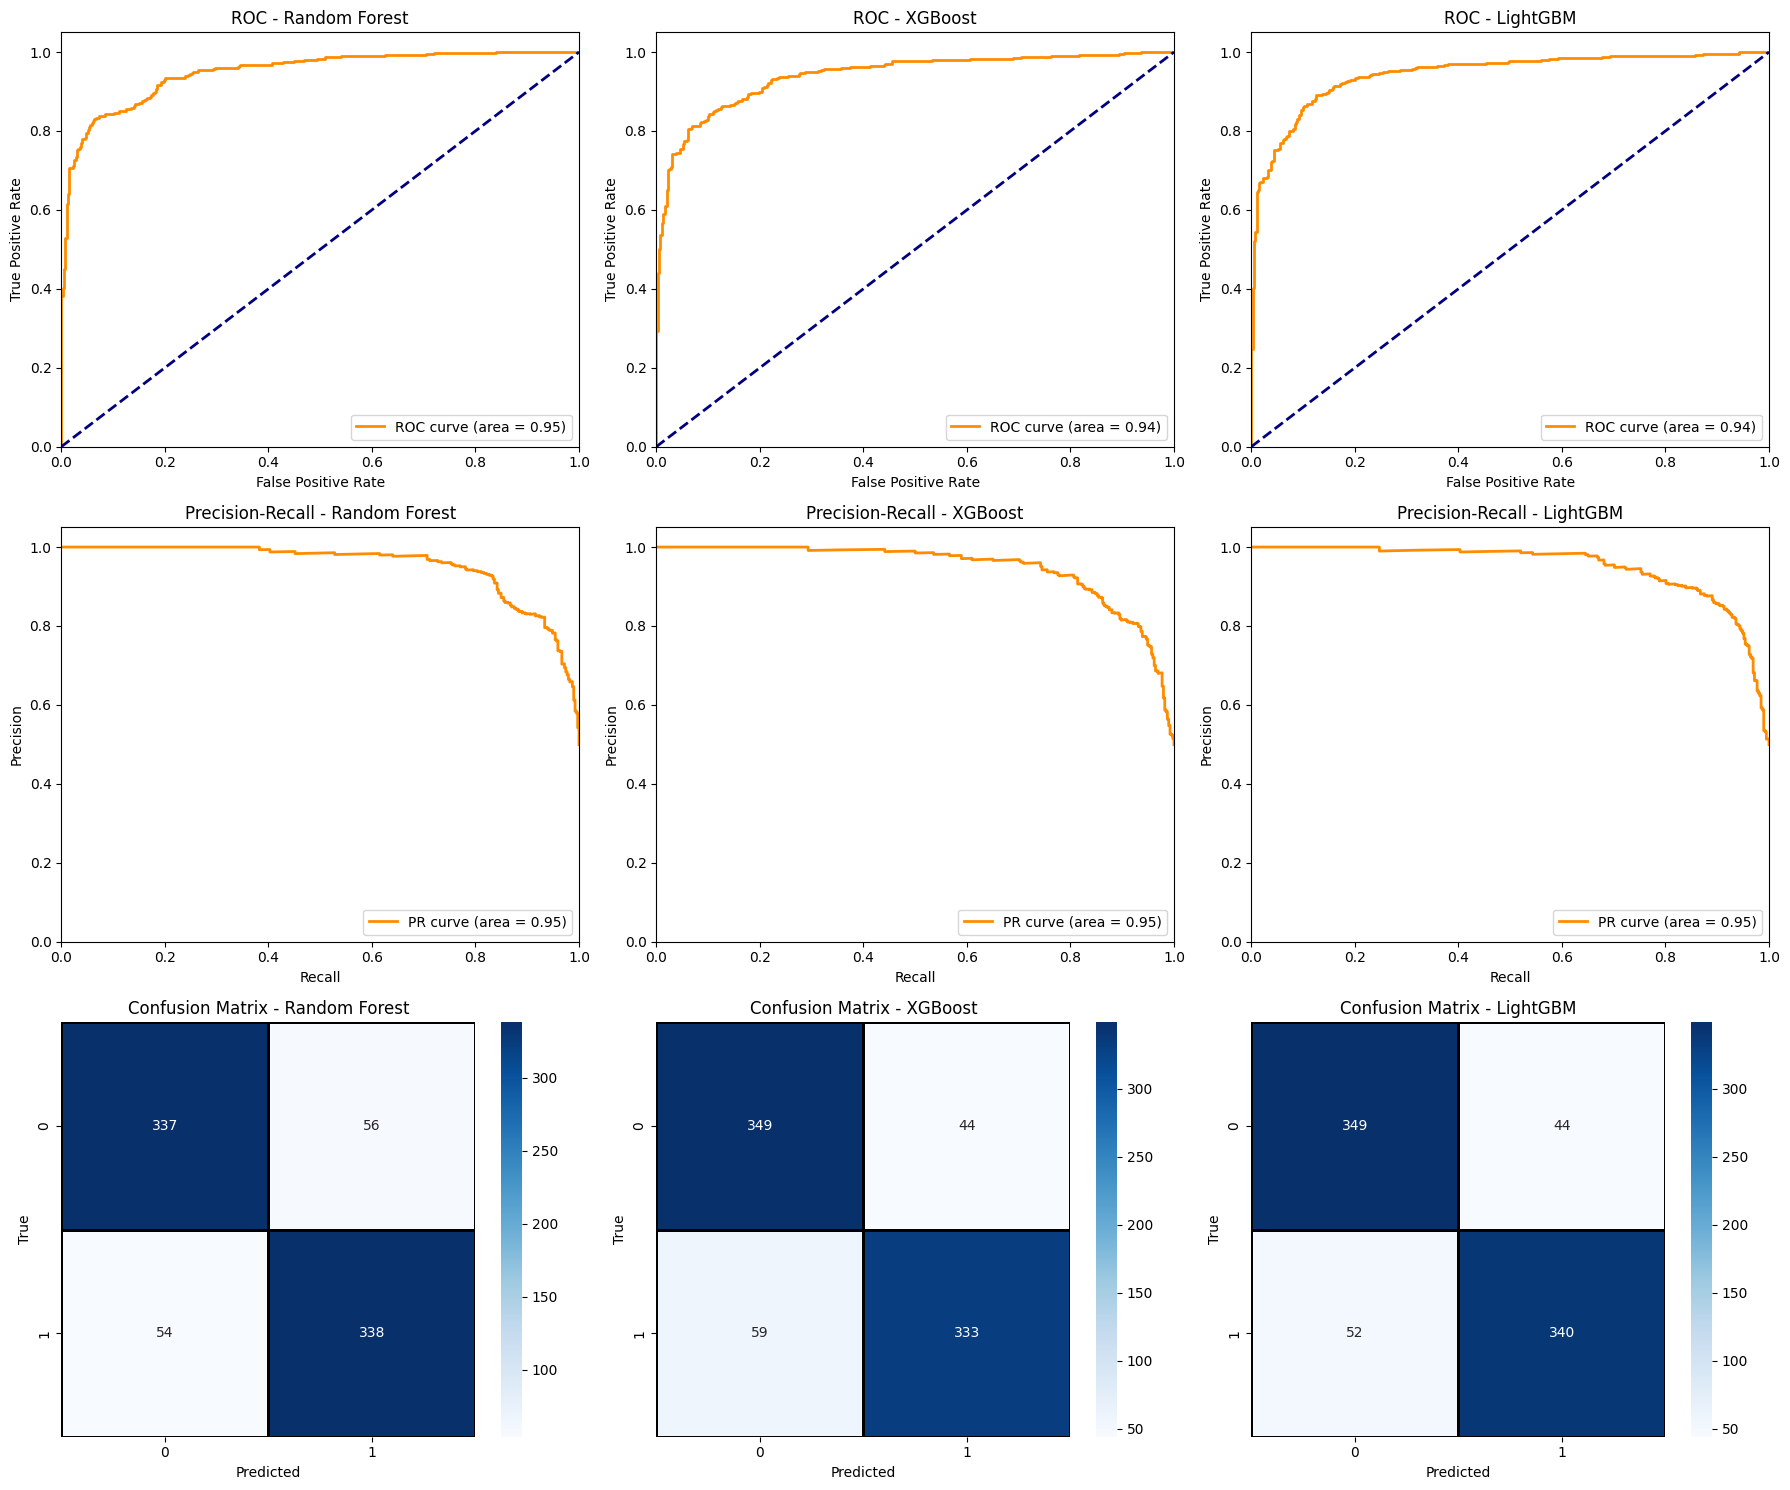

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.8598726114649682, 'Precision': 0.8578680203045685, 'Recall': 0.8622448979591837, 'F1 Score': 0.8600508905852418, 'ROC AUC': 0.9484732824427482}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.8687898089171975, 'Precision': 0.883289124668435, 'Recall': 0.8494897959183674, 'F1 Score': 0.8660598179453836, 'ROC AUC': 0.9395155008568312}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.8777070063694268, 'Precision': 0.8854166666666666, 'Recall': 0.8673469387755102, 'F1 Score': 0.8762886597938144, 'ROC AUC': 0.9441761437399387}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.8777070063694268,
 'Precision': 0.8854166666666666,
 'Recall': 0.8673469387755102,
 'F1 Score': 0.8762886597938144,
 'ROC AUC': 0.9441761437399387}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: LightGBM with Accuracy: 0.8777


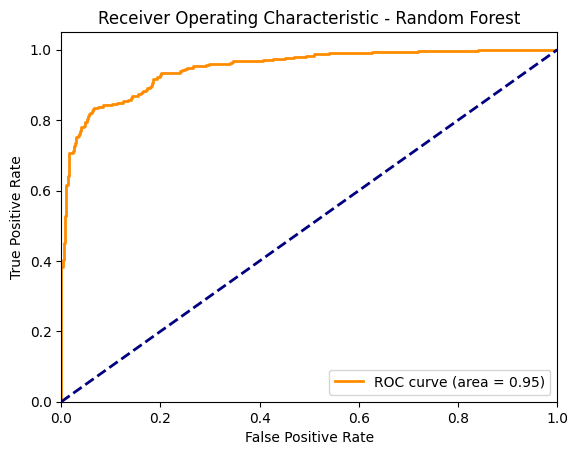

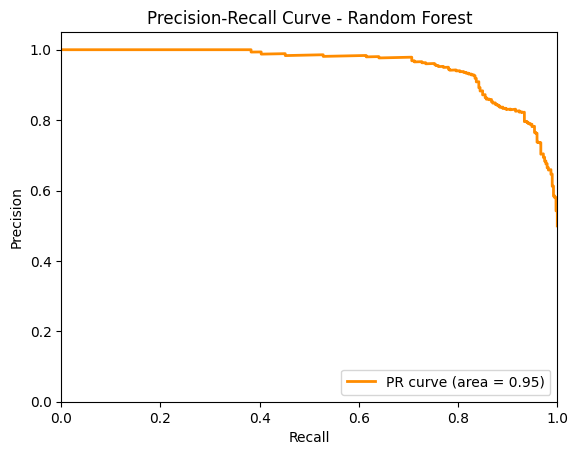

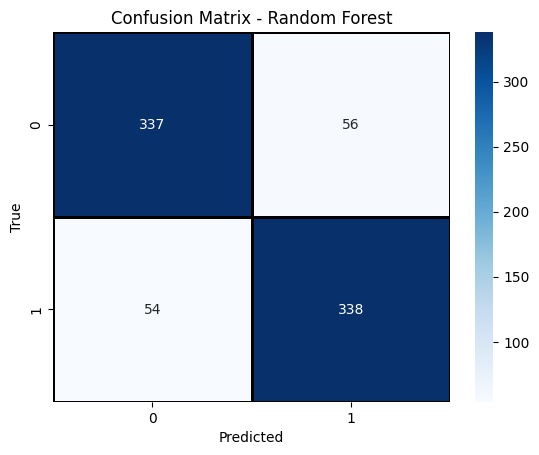

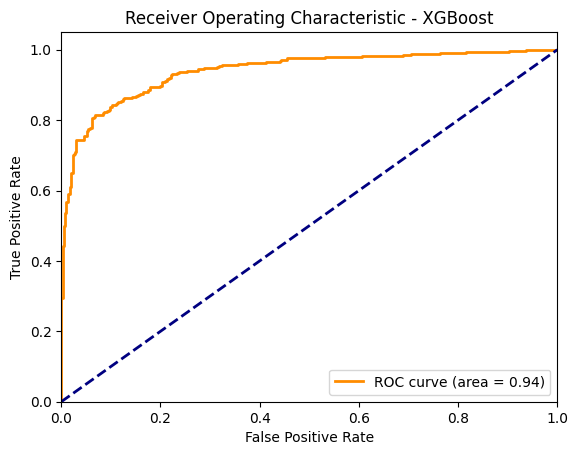

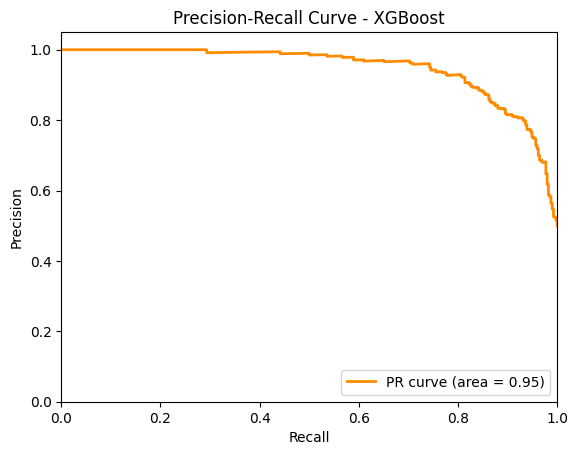

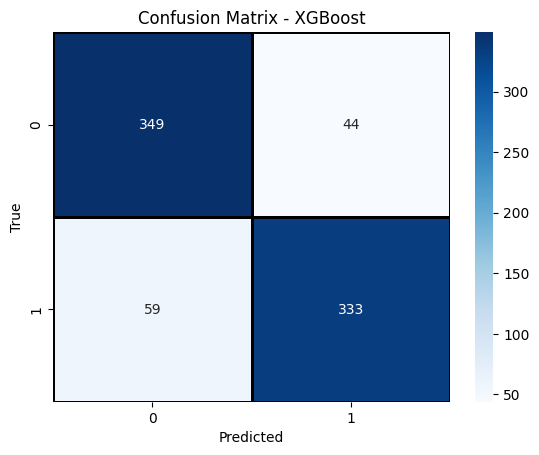

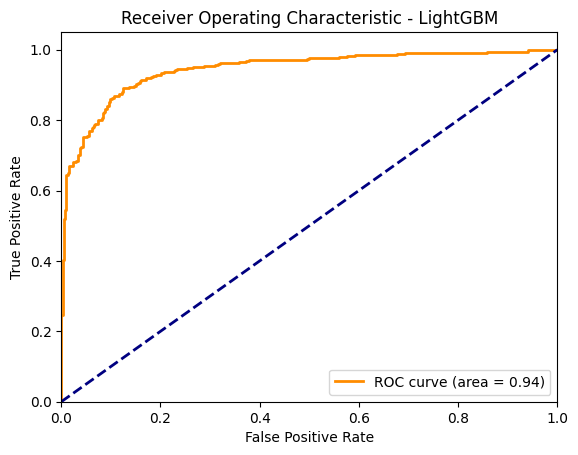

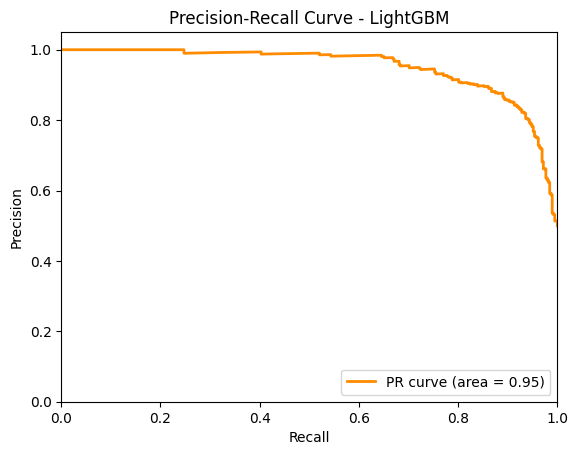

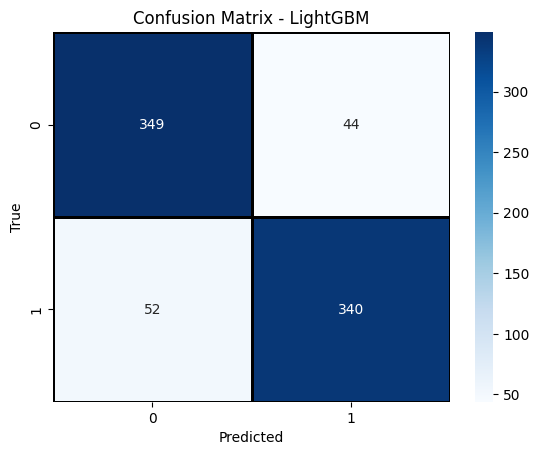

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

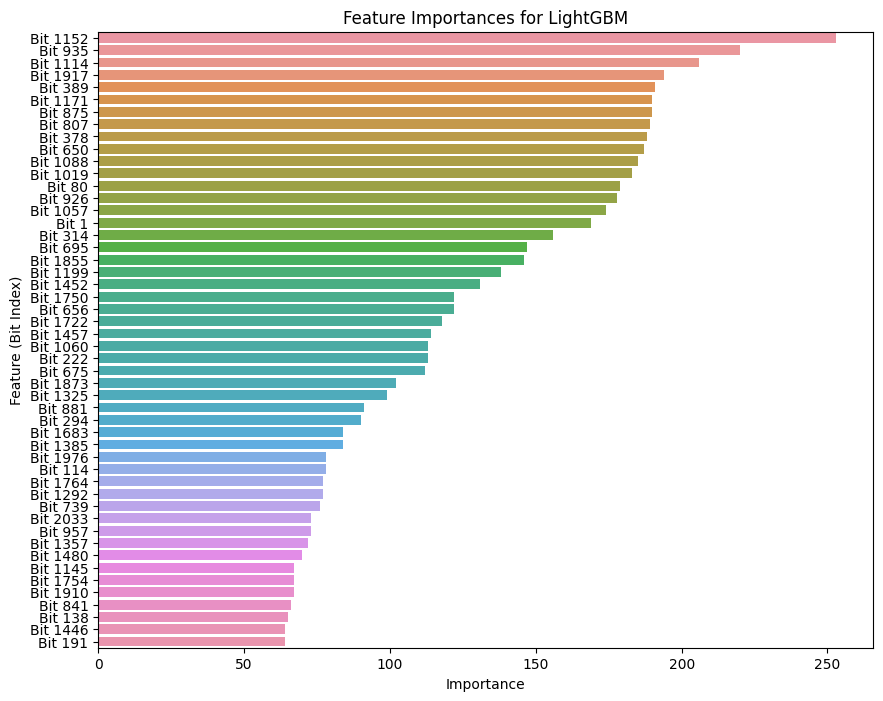

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
